## Sentiment Classification for Twitter feed data

This is a text analysis and sentiment classification project on data collected from microblogging platform twitter.com. I used tweepy API to collected 10931 tweets on the topic 'Coronavirus' and performed some basic exploratory data analysis on the tweets objects. I also performed sentiment classification on the tweets.

1. [Collecting Data](#1)

2. [Load dataset](#2)

3. [Exploratory Data Analysis](#3)

4. [Cleaning up Tweets](#4)

5. [Process tweets for feature extraction](#5)

6. [Feature Extraction](#6)

7. [Build and train classifiers](#7)

8. [Feature extraction using TFIDF Vectorizer](#8)

9. [Classification of collected tweets](#9)

## <a name="1">Collecting Data</a>

Let's collect real-time stream of tweets and store them in a text file.

In [7]:
from tweepy import OAuthHandler,Stream,API
from tweepy.streaming import StreamListener

# Variables that contains the user credentials to access Twitter API
access_token="ZZZZZZZZZZZZZZZ"
access_token_secret="XYZXYZXYZXYZXYZ"
consumer_key="XXXXXXXXXXXXXXX"
consumer_secret="YYYYYYYYYYYYYYY"

class StdOutListener(StreamListener):
    def on_data(self,data):
        with open("data/tweets.json","a") as f:
            f.write(data)
            return True
        return True
    def on_error(self,status):
        print(status)

if __name__=="__main__":
    # This handles Twitter authentification and the connection to Twitter Streaming API
    auth=OAuthHandler(consumer_key,consumer_secret)
    auth.set_access_token(access_token,access_token_secret)
    stream=Stream(auth,StdOutListener())
    # This line filter Twitter Streams to capture data by the keywords: "coronavirus","COVID2019","virus"
    stream.filter(track=["#coronavirus","#COVID2019","#virus"])

KeyboardInterrupt: 

Once we have all our data in a json file, we can parse the content and save it in a list:

In [1]:
import json

data=[]
with open("data/tweets.json","r") as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except:
            pass

print(len(data))

10931


## <a name="2">Load dataset</a>

In [3]:
import pandas as pd

tweets=pd.DataFrame(data)
tweets.head(5)

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,favorited,retweeted,filter_level,lang,timestamp_ms,display_text_range,extended_entities,possibly_sensitive,extended_tweet,withheld_in_countries
0,Mon Mar 30 10:07:48 +0000 2020,1244566993354842119,1244566993354842119,RT @GWGoldnadel: Quand je pense que ce chantre...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,...,False,False,low,fr,1585562868809,NaN,NaN,NaN,NaN,NaN
1,Mon Mar 30 10:07:48 +0000 2020,1244566993493254149,1244566993493254149,Thread on #coronavirus modelling ⬇️⬇️,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,...,False,False,low,en,1585562868842,NaN,NaN,NaN,NaN,NaN
2,Mon Mar 30 10:07:48 +0000 2020,1244566993455349760,1244566993455349760,Is that small amount to contribute covid 19,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,...,False,False,low,en,1585562868833,NaN,NaN,NaN,NaN,NaN
3,Mon Mar 30 10:07:48 +0000 2020,1244566993723895809,1244566993723895809,RT @CroixRouge: Découvrez #CroixRougeChezVous ...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,...,False,False,low,fr,1585562868897,NaN,NaN,NaN,NaN,NaN
4,Mon Mar 30 10:07:48 +0000 2020,1244566993820360705,1244566993820360705,RT @anp66: 4 #Coronavirus patients have been r...,"<a href=""http://iamsumane.lk"" rel=""nofollow"">S...",False,NaN,None,NaN,None,...,False,False,low,en,1585562868920,NaN,NaN,NaN,NaN,NaN


## <a name="3">Exploratory Data Analysis</a>

**Language Distribution**

Since people from around the World use twitter to tweet in different languages, we can find how tweets are distributed amongst which languages. We have an attribute 'lang' which is populated with the machine detected language of the tweet text. Let's take a look at the language distribution in our tweets

In [12]:
tweets.groupby("lang").size().sort_values(ascending=False).head()

lang
en    5479
fr    1446
es    1188
it     556
hi     377
dtype: int64

We can see that english is the most common language in our data.

**Trend Analysis with time series**

In [13]:
tweets["created_at"]=pd.to_datetime(pd.Series(tweets["created_at"]))

# set index to created_at
tweets.set_index("created_at",drop=False,inplace=True)

from pandas.tseries.offsets import DateOffset

# convert to 12 hour format
tweets.index=tweets.index-DateOffset(hours=12)

# created_at index is formatted to per minute
tweets_pm=tweets["created_at"].resample("1t",how="count")

Here is the graph of relevant tweets as a function of time:

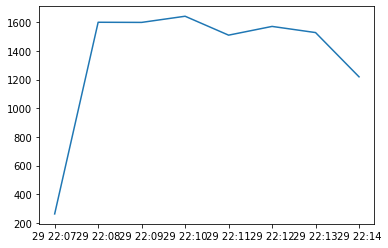

In [16]:
import matplotlib.pyplot as plt

plt.plot(tweets_pm)
plt.show()

**Frequency distribution of 25 most common words**

Filters out texts in tweets.csv, looking for relevant words, and plots a frequency distribution graph of those words using the NLTK platform.

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ajanthanelayathamby/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


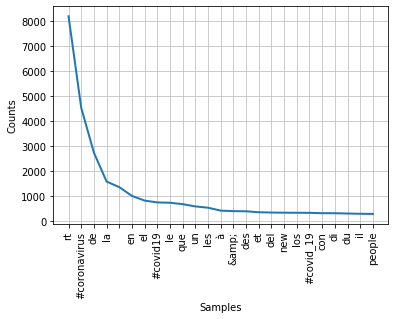

AxesSubplot(0.125,0.125;0.775x0.755)


In [17]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import FreqDist

# Get english stopwords
stop=stopwords.words("english")
texts=tweets["text"]

tokens=[]

# strip words of punctuation marks
for text in texts.values:
    tokens.extend([word.lower().strip(':,."-') for word in text.split()])

filtered_tokens=[word for word in tokens if not word in stop]

freq_dist=FreqDist(filtered_tokens)
print(freq_dist.plot(25))

Given the filter words, we expect coronavirus and covid2019 to be the most common words, so this is not surprising. We see, however, that rt, or retweets, is the most frequently used word. This indicates that many users were simply retweeting others comments.

**Most common users**

What are the users that people mentioned the most in our data set. Let's see the top 20 most common users mentioned.

In [18]:
import sys
from collections import Counter
import json

def get_users(tweet):
    entities=tweet.get("entities",{})
    users=entities.get("user_mentions",[])
    return [tag["name"].lower() for tag in users]

with open("data/tweets.json","r") as f:
    user_mentions=Counter()
    for line in f:
        try:
            tweet=json.loads(line,encoding="utf-8")
        except:
            pass
        users_in_tweet=get_users(tweet)
        user_mentions.update(users_in_tweet)
    for tag,count in user_mentions.most_common(20):
        print("{}: {}".format(tag,count))

conflits: 183
donald j. trump: 142
adam milstein: 112
allu arjun: 87
world health organization (who): 86
radiosavana: 70
sky news: 55
salud pública: 55
akhilesh mishra: 54
greg abbott: 46
ani: 45
ash mkhitaryan: 45
ben moore: 42
chrissy teigen: 40
g-william goldnadel: 37
global times: 35
juan luis steegmann olmedillas: 35
joe m: 34
abp news: 33
candace owens: 32


Let's visualize top 20 most mentioned users on a histogram:

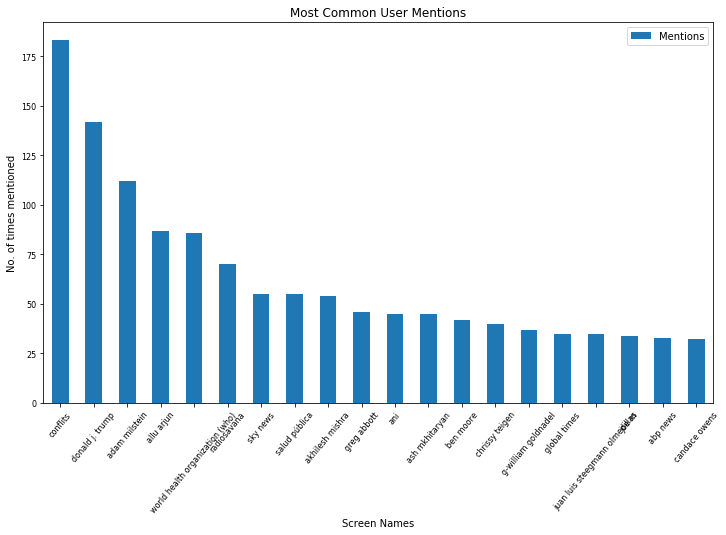

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

users=user_mentions.most_common(20)
x=list(range(1,21))

# data frame with screen names and number of times mentioned as columns
common_users=pd.DataFrame(users,index=x,columns=["Screen Names","Mentions"])

# Plotting the histogram
common_users.plot(x="Screen Names",y="Mentions",kind="bar",figsize=(12,7),fontsize=8,position=0.5,rot=50)
plt.title("Most Common User Mentions")
plt.ylabel("No. of times mentioned")
plt.xlabel("Screen Names")
plt.show()

## <a name="4">Cleaning up Tweets</a>

Before we can move on to sentiment analysis of our tweets text. We need to clean up our tweets to remove noisy data so that our classifiers work without any glitches. Data cleaning is the most important step in a data analysis pipeline. Models produce inaccurate results if we do not clean up data and since here we are dealing with text data posted by users around the World, we can be sure that there is a lot of noise in our data.

Let's begin with our cleaning process. First step is to filter english tweets from others as I, for now, wish to perform sentiment analysis only on tweets written in english language.

In [4]:
import pandas as pd

tweets_text=pd.DataFrame(data=tweets.get("text").loc[tweets["lang"]=="en"],index=None,columns=None,dtype=None,copy=True).reset_index(drop=True)
print(len(tweets_text))

5479


The code above filters tweets by language and saves tweets in english in data frame 'tweets_text'. We have 5479 english tweets.


Now we have only english Tweets in our data frame, we can begin our cleaning up process.

The steps in cleaning up tweets are as follows:
1. Convert to lower case. 'CORONAVIRUS', for example, becomes 'coronavirus'
2. We convert all links in the tweet text to URL and @usernames to AT_USER as these user mentions and links are of no use when performing sentiment analysis.
3. Change #hashtags to hashtags. Hashtags are of not much use for sentiment analysis, however, some hashtags do contain sentiments and we should not discard them all together. We instead convert them to words and strip '#'. For example '#Coronavirus patients' now becomes 'Coronavirus patients'
4. We strip punctuations, additional white spaces etc.

In [5]:
# Cleaning up tweets
import re

def clean_tweet(tweet):
    # Convert to lower case
    tweet=tweet.lower()
    # Remove additional white spaces
    tweet=re.sub("[\s]+"," ",tweet)
    # Convert www.* or https?://* to URL
    tweet=re.sub("((www\.[^\s]+)|(https?://[^\s]+))","URL",tweet)
    # Convert @username to AT_USER
    tweet=re.sub("@[^\s]+","AT_USER",tweet)
    # Replace #word with word
    tweet=re.sub(r'#([^\s]+)',r'\1',tweet)
    # trim
    tweet=tweet.strip('\'"')
    return tweet

text=tweets_text["text"].values.tolist()
len(text)
clean_tweets=[]
for i in text:
    clean_tweets.append(clean_tweet(i))

len(clean_tweets)

5479

Let's pass a tweet from our original dataset through our function and see how it performs.

In [6]:
# original tweet
print(tweets_text["text"].iloc[2])

# cleaned up tweet
print(clean_tweet(tweets_text["text"].iloc[2]))

RT @anp66: 4 #Coronavirus patients have been recovered and discharged from IDH hospital as total recovered no increased to 15 now #lka #sri…
rt AT_USER 4 coronavirus patients have been recovered and discharged from idh hospital as total recovered no increased to 15 now lka sri…


## <a name="5">Process tweets for feature extraction</a>

To perform sentiment analysis we need to extract features from our text. Features are nothing but individual words from tweets that are categorized as 'positive', 'negative' and 'neutral' based on the sentiment. Once we extract all the features, we select useful features that help us build effective models.

Below are the steps that we follow to process our tweets for feature extraction:
1. Tokenization: We strip each tweets into words
2. Normalization: Converting text to canonical form. For example, "we're" is converted to "we are".
3. Stop Words removal: Some words in english do not have a useful meaning or sentiment. "The", "in" "a" are examples of stop word. It's better to remove these words because they would be useless as features.

In [7]:
import string
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

# tokenization
def process(tweet,tokenizer=TweetTokenizer(),stopwords=[]):
    tokens=tokenizer.tokenize(tweet)
    return [tok for tok in tokens if tok not in stopwords and not tok.isdigit()]

tweet_tokenizer=TweetTokenizer()
punct=list(string.punctuation)
stopword_list=stopwords.words("english")+punct+["rt"+"via","...","AT_USER","URL","'"]

# normalization
def normalize_contractions(tokens,stopwords=[]):
    token_map={
        "i'm":"i am",
        "you're":"you are",
        "it's":"it is",
        "we're":"we are",
        "we'll":"we will",
        "ain't":"are not",
        "ive":"i have",
        "aint":"are not"
    }
    for tok in tokens:
        if tok in token_map.keys():
            for item in token_map[tok].split():
                if item not in stopwords:
                    yield item
        else:
            yield tok

Now that we have tokenization and normalization functions in place, let's do a test run.

We pass a cleaned up tweet through process function to tokenize and remove stop words and then we pass the tokens through our normalize function.

In [8]:
test_clean=clean_tweet(u"ain't we going to the GreAt wall of CHINA??!!")
test_process=process(test_clean,stopwords=stopword_list)
test_normalize=normalize_contractions(test_process)

print(test_process)
print(list(test_normalize))

["ain't", 'going', 'great', 'wall', 'china']
['are', 'not', 'going', 'great', 'wall', 'china']


We can choose to not remove stopwords while either tokenizing or normalizing using our process and normalize_contractions functions. In the test example above, I chose to ignore stopword argument through normalize_contraction to check if it works fine. As we can see, both our functions provided the expected output.

## <a name="6">Feature Extraction</a>

Once we are done with cleaning up and pre processing, next step is to extract features from our data. We write a feature extraction function to perform this task.

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def replace_two_or_more(s):
    # Look for 2 or more repetitions of character and replace with the character itself
    pattern=re.compile(r"(.)\1{1,}",re.DOTALL)
    return pattern.sub(r"\1\1",s)

def get_feature_vector(tweet):
    feature_vector=[]
    stopword_list=stopwords.words("english")+punct+["rt","via","...","AT_USER","URL","https","'"]
    words=list(normalize_contractions(process(tweet,tokenizer=tweet_tokenizer,stopwords=stopword_list),stopwords=stopword_list))
    for w in words:
        # replace two or more with two occurrences
        w=replace_two_or_more(w)
        # check if the word starts with an alphabet letter
        val=re.search(r"^[a-zA-Z][a-zA-Z0-9]*$",w)
        if val is None:
            continue
        else:
            feature_vector.append(w.lower())
    return feature_vector

The data we collected is not labeled with a true class catagory and we need an already labeled data set to train our classifiers. I downloaded a data set of imdb reviews of movies and sentiment associated with the reviews: 0 being negative sentiment and 1 being positive.

We'll use this labeled data set to train the classifiers and test the accuracy of predictions. We can thereafter use the trained classifier to perform sentiment classification on the data we collected.

Below is the snippet to clean, pre process and extract features from the data set.

In [10]:
import csv
import nltk

imdb_data=csv.reader(open("data/imdb_labelled.txt","r"),delimiter="\t",quotechar="|")
labelled_tweets=[]
for row in imdb_data:
    sentiment=row[1]
    text=row[0]
    trained_clean=clean_tweet(text)
    feature_vector=get_feature_vector(trained_clean)
    labelled_tweets.append((feature_vector,sentiment))

labeled_tweet is list that consists of meaningful words(features) from each tweet and the label associated with it.

As we print labeled_tweets below, we can see that it's a list of meaningful clean tweets along with sentiment label, where each tweet has been cleaned, normalized and preprocessed

In [ ]:
print(labelled_tweets)

Now let's create a list of only word features without label and print the list.

In [ ]:
def words_in_tweets(labelled_tweets):
    all_words=[]
    for (words,sentiment) in labelled_tweets:
        all_words.extend(words)
    return all_words

word_features=words_in_tweets(labelled_tweets)
print(word_features)

Before we move on to building our classifiers, we need one last modification in our labeled data structure. Vectorizers in SciKit learn accept raw text to convert features(useful words) to vectors and we have a list of strings which the vectorizer won't accept. Hence, we write a function to join a list of strings into a sentence i.e. raw text. We apply that function to our data frame and see what it looks like.

In [12]:
def join_words(words):
    return(" ".join(item for item in words))

import pandas as pd

labelled_data=pd.DataFrame((labelled_tweets),columns=("Vectors","label"),copy=True)
labelled_data["Vectors"]=labelled_data["Vectors"].apply(func=join_words)
labelled_data.head()

,Vectors,label
0,aimless movie distressed drifting young man,0
1,sure lost flat characters audience nearly half...,0
2,attempting artiness black white clever camera ...,0
3,little music anything speak,0
4,best scene movie gerardo trying find song keep...,1


As we can see, the text in each row is clean and processed i.e. normalized, without punctuations and stop words. This is the clean data that we'll use to pass through our classifier. Please note that all the words that were originally in our raw imdb dataset are in our new training_data except the stop words. However, should we use all these words to train our classifier? We sure could, but in machine learning, adding more number of features after a certain point doesn't only makes our model heavy on computation and memory which increases space time complexity but also could negatively effect the accuracy because of useless features acting as noise.

Hence, we select useful features that give the highest possible accuracy without compromising on efficiency in terms of time and memory. We are going to use a few methods of feature selection and see how our classifier performs. Let's start with the bag of words model which is nothing but the countvectorizer method which selects features(words) based on their term frequency i.e. how many times a word appears in a document (which in our case is a tweet/movie review)

Now let's examine our training_data.

In [13]:
labelled_data.label.value_counts()

1    500
0    500
Name: label, dtype: int64

Our labeled data is equally divided between negative and positive classes. Now let's divide our data between X variables i.e. the features/predictors and y variable which is the prediction/label/class.

In [14]:
X=labelled_data["Vectors"]
y=labelled_data["label"]
print(X.shape)
print(y.shape)

(1000,)
(1000,)


Now it's time to randomly split our labeled data into training and test set

In [15]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(750,)
(250,)
(750,)
(250,)


In [ ]:
print(X_test)

**Bag of words feature selection**

Finally we have separate training and test data sets for predictors and classes, we can now convert our features into vectors using count vectorizer which is nothing but bag of words model. The snippet below performs the following:
1. Convert words in training predictor data to vectors using CountVectorizer based on their term frequency and keep only the most useful features.
2. Use those vectors to create a sparse matrix using fit_transform function which will train our classifiers.
3. We examine the size of features selected by CountVectorizer and compare it with total number of features i.e. all the useful words we had in labeled tweets

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer=CountVectorizer(analyzer="word",preprocessor=None,tokenizer=None,stop_words=stopword_list,lowercase=None)

X_train_dtm=vectorizer.fit_transform(X_train)
vocab=vectorizer.get_feature_names()
print(len(vocab))
print(len(word_features))
X_train_dtm

2295
7124


<750x2295 sparse matrix of type '<class 'numpy.int64'>'
	with 5187 stored elements in Compressed Sparse Row format>

As we can see above, the size of feature vocabulary selected by vectorizer is 2296 and total number of features i.e. meaningful words we had in our labeled data are 7124. This is significant feature space reduction. Also, we now have a sparse matrix from our selected features.

We also need to create a sparse matrix from test predictors to be able to predict their class.

In [18]:
X_test_dtm=vectorizer.transform(X_test)
X_test_dtm

<250x2295 sparse matrix of type '<class 'numpy.int64'>'
	with 1245 stored elements in Compressed Sparse Row format>

## <a name="7">Build and train classifiers</a>

We are now ready to train classifiers. We will be using SciKit learn machine learning module to call classifiers that we wish to use. We will train the classifiers by passing training set predictor sparse matrix (X_train_dtm) and training set response matrix (y_train) through them. Remember, the predictor sparse matrix contains features selected by CountVectorizer (Bag of words) which means that we are using only those features to train the classifiers.

To predict, we'll use predictor test data sparse matrix (X_test_dtm). Although we already have true class labels for test data set, we will still not use this data set to train the classifiers as we need the true class labels later to compare with the predicted class label to calculate the accuracy of the classifiers.

If we train our classifiers with all the labeled data, we will not be able to test the accuracy of our classifier as the classifier will already be trained on all the labeled data set. This is the reason why we need to split labeled data into training and test set. Of course, once we have our final classifier ready for a real world application, we can use all our labeled data to train the classifier as the more trained it is, the better it will perform.

**Naive Bayes Classifier**

The first classifier we are going to use is the Naive Bayes classifier. Naive Bayes, although a simple approach, is usually the best choice for text classification purpose. Naive Bayes is a simple probabilistic classifier based on Bayes theorem that assumes independence between features. Below are the steps to perform classification with SciKit learn library:
1. Initiate the classifier.
2. Train the classifier with predictor sparse matrix.
3. Perform prediction on test data i.e by passing test data sparse matrix through predict method.
4. Save the predictions to calculate accuracy.

In [19]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

clf=MultinomialNB()

# train the model using X_train_dtm (timing it with an IPython "magic command")
%time clf.fit(X_train_dtm,y_train)

# make class predictions for X_test_dtm
y_pred=clf.predict(X_test_dtm)

CPU times: user 2.31 ms, sys: 208 µs, total: 2.52 ms
Wall time: 2.43 ms


Now that we have class predictions saved in y_pred, we can calculate the accuracy of the classifier by comparing y_pred and y_test

In [20]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_pred)

0.812

Great! Naive Bayes predicted the class of test data with 81.2% accuracy. We can fine tune this classifier by tuning a few parameters and trying different feature selection methods, but we'll get it later. For now, let's try other classifiers with the same set of features and see how they perform.

Now let's look look at the confusion matrix to see how many type 1 and type 2 errors the Naive Bayes classifier produced.

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,y_pred)

array([[102,  24],
       [ 23, 101]])

24 false positive and and 23 false negative errors. Let's look at the list of false positive errors.

In [ ]:
# print false positive
X_test[y_pred>y_test]

**Logistic Regression**

Now let's the same classification using Logistic Regression or Maximum Entropy classifier. This classifier is also a probabilistic classifier like Naive Bayes but unlike the Naive Bayes classifier, the Max Entropy does not assume that the features are conditionally independent of each other. The MaxEnt is based on the Principle of Maximum Entropy and from all the models that fit the training data, selects the one which has the largest entropy.

Now let's perform classification using Max Entropy classifier.

In [23]:
from sklearn.linear_model import LogisticRegression

clf=LogisticRegression()

%time clf.fit(X_train_dtm,y_train)

y_pred=clf.predict(X_test_dtm)

accuracy_score(y_test,y_pred)

CPU times: user 4.87 ms, sys: 2.65 ms, total: 7.52 ms
Wall time: 16.3 ms


0.792

The classifier performed fairly well with an accuracy of 79.2%. Let's examine the confusion matrix to see where it made more errors than Naive Bayes classifier.

In [24]:
confusion_matrix(y_test,y_pred)

array([[104,  22],
       [ 30,  94]])

Upon comparing, we can see here that maximum entropy classifier made more false positive errors than than Naive Bayes classifier.

**SVM (Support Vector Machines)**

A Support Vector Machine (SVM) is a non probabilistic classifier which separates examples of one category from another category by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. Let's call this classifier from SciKit learn module and see how it performs on the same training and test data.

In [25]:
from sklearn.svm import LinearSVC

clf=LinearSVC()

%time clf.fit(X_train_dtm,y_train)

y_pred=clf.predict(X_test_dtm)

accuracy_score(y_test,y_pred)

CPU times: user 5.27 ms, sys: 1.04 ms, total: 6.31 ms
Wall time: 5.5 ms


0.756

Compared with above 2 classifiers, SVM performed with least accuracy. Let's examine the confusion matrix

In [26]:
confusion_matrix(y_test,y_pred)

array([[98, 28],
       [33, 91]])

Most number of false negative as well as false positive errors compared with the above 2 classifiers.

## <a name="8">Feature extraction using TFIDF Vectorizer</a>

We have already trained classifiers using feature selection by Countvectorizer i.e. bag of words model. Let's see if our classification models perform better using TFIDF vectorizer.

Whereas count vectorizer counts word frequencies, in the case of TFIDF Vectorizer, the value increases proportionally to count of the word frequency, but is offset by the frequency of the word in the corpus.

The frequency offset is taken care by the inverse document frequency (IDF) part. For example, without IDF, a word like 'the'(assuming we do not remove stop words), which is one of the most commonly used words in english yet meaningless in context of text classification would bear a higher weight than less frequent yet meaningful words.

Let's use TfidfVectorizer to convert the training data set into vector matrix to train the classifiers and check if this improves their accuracy.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer=TfidfVectorizer(analyzer="word",preprocessor=None,tokenizer=None,stop_words=stopword_list,binary=None,lowercase=None)

X_train_dtm=vectorizer.fit_transform(X_train)
X_test_dtm=vectorizer.transform(X_test)

# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

clf=MultinomialNB()

# train the model using X_train_dtm (timing it with an IPython "magic command")
%time clf.fit(X_train_dtm,y_train)

# make class predictions for X_test_dtm
y_pred=clf.predict(X_test_dtm)

from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_pred)

CPU times: user 1.94 ms, sys: 34 µs, total: 1.97 ms
Wall time: 1.98 ms


0.812

In [28]:
from sklearn.linear_model import LogisticRegression

clf=LogisticRegression()

%time clf.fit(X_train_dtm,y_train)

y_pred=clf.predict(X_test_dtm)

accuracy_score(y_test,y_pred)

CPU times: user 2.81 ms, sys: 923 µs, total: 3.73 ms
Wall time: 2.91 ms


0.804

In [29]:
from sklearn.svm import LinearSVC

clf=LinearSVC()

%time clf.fit(X_train_dtm,y_train)

y_pred=clf.predict(X_test_dtm)

accuracy_score(y_test,y_pred)

CPU times: user 3.77 ms, sys: 729 µs, total: 4.5 ms
Wall time: 3.48 ms


0.792

It is clear from comparison that the classifier that performs the best with respect to training and test data set in our case is Naive Bayes with TFIDF Vectorizer with maximum accuracy 81.2%. It's no surprise as TFIDF Vectorizer and Naive Bayes classifier are the most popular choices for such a text classification purpose.

## <a name="9">Classification of collected tweets</a>

**Step 1: Prepare tweets for classifier**

In [43]:
# Process, clean and extract features to prepare for classifier
processed_tweets=[]
for item in clean_tweets:
    feature_vector=get_feature_vector(item)
    joined_strings=join_words(feature_vector)
    processed_tweets.append(joined_strings)

collected_tweets=pd.DataFrame(processed_tweets)
collected_tweets.head()
test_collected_tweets=collected_tweets[0]

**Step 2: Train Naive Bayes classifier to classify our collected tweets**

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer=TfidfVectorizer(analyzer="word",preprocessor=None,tokenizer=None,stop_words=stopword_list,binary=None,lowercase=None)

X_train_dtm=vectorizer.fit_transform(X_train)
X_test_dtm=vectorizer.transform(test_collected_tweets)

# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

clf=MultinomialNB()

# train the model using X_train_dtm (timing it with an IPython "magic command")
%time clf.fit(X_train_dtm,y_train)

# make class predictions for X_test_dtm
y_pred=clf.predict(X_test_dtm)

CPU times: user 1.86 ms, sys: 5 µs, total: 1.87 ms
Wall time: 1.87 ms


**Classification Results**

Our Classifier has now classified all the tweets. Now let's prompt user to enter the index of the tweet and print the sentiment as well as the tweet.

In [ ]:
string=input("Please mention a tweet index number ")
x=int(string)
print("Tweet: {}".format(clean_tweets[x]))
print("Sentiment: {}".format(y_pred[x]))